# Multivariate Regression

# Show the collections that have been generated

In [57]:
from pymongo import MongoClient
from process_collection import *
#  IMPORTANT:  Set these for each run:
#################################################
# mongoServer = None   # use the local mongodb server installed on your computer
#mongoServer = 'mongodb://server.mcgarity.info:27017/'  # Art's personal server
#mongoServer = 'mongodb://ubuntu:27017/'  # ubuntu Linux virtual machine on Art's Mac
mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
database = "jcohen4"
username = "jcohen4"
password = "wingohocking"
authenticationDatabase = "jcohen4"

client = MongoClient(mongoServer)
################################################

db = client[database]
db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
collectionNames = sorted(db.collection_names())
collectionNames

[u'2008',
 u'2008trial1',
 u'2008trial3',
 u'2008trial4',
 u'2008trial6',
 u'first_wingo_test',
 u'fourth_wingo_test',
 u'impervFixed',
 u'impervNotFixed',
 u'july',
 u'july10',
 u'july12',
 u'july13',
 u'july14',
 u'july15',
 u'july16',
 u'july17',
 u'july2',
 u'july21',
 u'july22',
 u'july23',
 u'july24',
 u'july3',
 u'july4',
 u'july5',
 u'july6',
 u'july7',
 u'july8',
 u'july9',
 u'largeTrialLinier',
 u'multivariate_250_2010',
 u'multivariate_random_250_2010',
 u'multivariate_random_250_2011',
 u'multivariate_random_250_2012',
 u'multivariate_random_250_2013',
 u'randomTrial1',
 u'randomTrial2',
 u'randomTrial4',
 u'randomTrial5',
 u'random_multivariate',
 u'random_multivariate2',
 u'random_multivariate2009',
 u'random_multivariate2009year',
 u'random_multivariate2010',
 u'random_multivariate2012year',
 u'random_multivariate250',
 u'random_multivariate250_2009',
 u'random_multivariate3',
 u'random_multivariate5',
 u'random_multivariate6',
 u'random_multivariate7',
 u'random_multiva

In [58]:
from get_cso import calculate_cso
acft_to_mgal = 0.325851  # 1 acre-ft = 0.325851 MGal
collectionName = 'y16m12d19_AEM_Wakefield_and_Anna_50_250'
runs = db[collectionName]
cursor = runs.find()
noLidRun = cursor[0]
noLidVolume = noLidRun['volume']  # 10^6 Gal / yr
noLidPeak = noLidRun['peak']   # cfs
noLidRunoff = noLidRun['runoff']  # acre-ft/yr
outflowSeries = noLidRun['outflow_series']
ratio = 0.05
csoResults = calculate_cso(outflowSeries,ratio)
csoVolumeMGal = csoResults['cso_volume']/1e6
print "noLidPeak = %0.2f cfs, noLidVolume = %0.2f MGal" % (noLidPeak,noLidVolume)
print "noLid Runoff = %0.2f acre-ft = %0.2f MGal" % (noLidRunoff,noLidRunoff*acft_to_mgal)
print "noLid csoVolumeMGal = %0.2f MGal" % csoVolumeMGal
# NOTE: Volume is total flow volume at sewer outlet while Runoff is total runoff volume
#       so they will likely be slightly different
noLidRunParamsList = noLidRun['runParamList']
#print noLidRunParamsList

noLidPeak = 1948.45 cfs, noLidVolume = 1948.90 MGal
noLid Runoff = 5987.73 acre-ft = 1951.11 MGal
noLid csoVolumeMGal = 687.45 MGal


In [59]:
# Compute Annual CSO Flows from results stored on Mongo
from get_cso import * 
from process_collection import * 
collectionName = 'y16m12d19_AEM_Wakefield_and_Anna_50_250'
ratio = 0.05
numSubcatch = 7
numLID = 2
numVariables = numSubcatch*numLID
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName, numVariables, db)
volReduction = results["volReductionList"]
numberOfRuns = len(volReduction)
volReductionMgal = [x / 1e6 for x in volReduction]
numberOfRuns = len(volReductionMgal)
#print volReduction
# ALERT:  in cso_reduction, collectionName and numSubCatch is never used !!!
csoResults = cso_reduction(collectionName, ratio, numSubcatch, results) 
csoReduction = csoResults["csoReduction"]
csoReductionMgal = [x / 1e6 for x in csoReduction]
#print csoReduction
cso = csoResults["cso"]
#print cso
totVol = csoResults["totalVol"]
print "Number of Runs stored in Database = %d" % numberOfRuns

Number of Runs stored in Database = 528


In [60]:
# Multivariable Regression for Annual CSO Volumes
import numpy as np
import statsmodels.api as sm
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics
### regression
y = csoResults["csoReduction"]
# list of variable values (LID numbers) for each random LID placement:
X = results['numLists']   # a list of lists (so upper case)
stats = reg_m(y,X)
print "Exact r-squared:"
print stats.rsquared
print stats.summary()
print stats.params
#print X

Exact r-squared:
0.999895587246
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.509e+05
Date:                Thu, 22 Dec 2016   Prob (F-statistic):               0.00
Time:                        14:55:44   Log-Likelihood:                -7147.7
No. Observations:                 528   AIC:                         1.433e+04
Df Residuals:                     513   BIC:                         1.439e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          7.719e+0

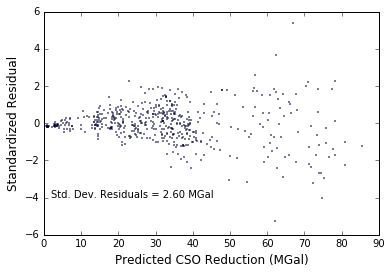

In [61]:
# Generate Residuals Plot for Annual CSO Volumes
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# First, transpose results['numLists']:
xVals = zip(*results['numLists'])
#print list(xvals[0])

betaZero = stats.params[numVariables]
yPredicted = []
for xTuple in xVals:
    i = 0
    yval = betaZero
    for beta in stats.params:
        yval += beta*xTuple[i]
        i += 1
        if i == numVariables:
            break
    yPredicted.append(yval/1e6)  # convert to 10^6 Gal
residuals = []
i = 0
for ySWMM in csoReductionMgal:
    #print ySWMM
    resid = ySWMM - yPredicted[i]  # Residual in 10^6 Gal
    residuals.append(resid)
    i+=1
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]
(fig, ax1) = plt.subplots()
ax1.plot(yPredicted,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResiduals
ax1.text(2,-4,stdDevText)

In [62]:
# Multivariable Regression for Sewer Outflow Volume
import numpy as np
import statsmodels.api as sm
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics
### regression
y = volReduction
# list of variable values (LID numbers) for each random LID placement:
X = results['numLists']   # a list of lists (so upper case)
stats = reg_m(y,X)
print "Exact r-squared:"
print stats.rsquared
print stats.summary()
print stats.params
#print X

Exact r-squared:
0.999962233738
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.702e+05
Date:                Thu, 22 Dec 2016   Prob (F-statistic):               0.00
Time:                        14:55:45   Log-Likelihood:                -7137.5
No. Observations:                 528   AIC:                         1.430e+04
Df Residuals:                     513   BIC:                         1.437e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          1.206e+0

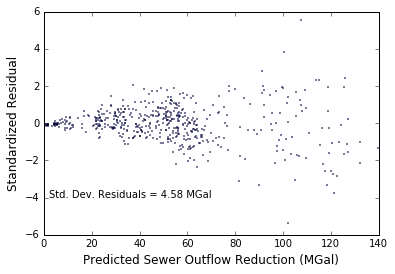

In [63]:
# Generate Residuals Plot for Sewer Outflow Volume
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# First, transpose results['numLists']:
xVals = zip(*results['numLists'])
#print list(xvals[0])

betaZero = stats.params[numVariables]
yPredicted = []
for xTuple in xVals:
    i = 0
    yval = betaZero
    for beta in stats.params:
        yval += beta*xTuple[i]
        i += 1
        if i == numVariables:
            break
    yPredicted.append(yval/1e6)  # convert to 10^6 Gal
residuals = []
i = 0
for ySWMM in volReductionMgal:
    #print ySWMM
    resid = ySWMM - yPredicted[i]  # Residual in 10^6 Gal
    residuals.append(resid)
    i+=1
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]
(fig, ax1) = plt.subplots()
ax1.plot(yPredicted,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted Sewer Outflow Reduction (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResiduals
ax1.text(2,-4,stdDevText)

Total number of SWMM runs = 528
[ 0.61315377  0.22928991]


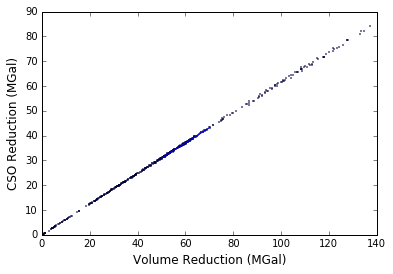

In [64]:
# SCATTER PLOT OF CSO ANNUAL VOLUME REDUCTION VS SEWER OUTFLOW ANNUAL VOLUME REDUCTION
%matplotlib inline
import matplotlib.pyplot as plt
print "Total number of SWMM runs = %d" % len(volReductionMgal)
#xRange = [50,70]
#yRange = [25,45]
# fit a straight line to CSO volume vs Outflow volume:
VolumeRed = []
VolumeRed.append(volReductionMgal)
stats = reg_m(csoReductionMgal,VolumeRed)
print stats.params
a = stats.params[1]  # intercept
b = stats.params[0]  # slope
xline = []
yline = []
for xval in range(xRange[0],xRange[1]+1, 1):
    xline.append(xval)
    yval = a + b*xval
    yline.append(yval)
(fig, ax1) = plt.subplots()
ax1.plot(volReductionMgal,csoReductionMgal,'ko',color = 'b',markersize = 1)
ax1.plot(xline,yline)
ax1.set_xlabel("Volume Reduction (MGal)",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal)",fontsize=12)
#plt.xlim(xRange)
#plt.ylim(yRange)

In [65]:
### regression for total volume outflow
y = csoResults["totalVol"]
#print y
x = results['numLists']
#print x
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics
reg_m(y,x)

print "Exact r-squared:"
print reg_m(y, x).rsquared
print reg_m(y, x).summary()


Exact r-squared:
0.999959550874
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.059e+05
Date:                Thu, 22 Dec 2016   Prob (F-statistic):               0.00
Time:                        14:55:45   Log-Likelihood:                -7156.4
No. Observations:                 528   AIC:                         1.434e+04
Df Residuals:                     513   BIC:                         1.441e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -1.211e+0